In [1]:
import pandas as pd
import math
import numpy as np

# keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization, Activation
from tensorflow.keras.losses import MeanSquaredError
from keras.callbacks import EarlyStopping

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,OneHotEncoder

# **1. Xử lý dữ liệu**

In [2]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/electric-vehicle-battery-life-prediction/dataset/cleaned_dataset/metadata.csv")
df

,type,start_time,ambient_temperature,battery_id,test_id,uid,filename,Capacity,Re,Rct
0,discharge,[2010. 7. 21. 15. 0. ...,4,B0047,0,1,00001.csv,1.6743047446975208,NaN,NaN
1,impedance,[2010. 7. 21. 16. 53. ...,24,B0047,1,2,00002.csv,NaN,0.05605783343888099,0.20097016584458333
2,charge,[2010. 7. 21. 17. 25. ...,4,B0047,2,3,00003.csv,NaN,NaN,NaN
3,impedance,[2010 7 21 20 31 5],24,B0047,3,4,00004.csv,NaN,0.05319185850921101,0.16473399914864734
4,discharge,[2.0100e+03 7.0000e+00 2.1000e+01 2.1000e+01 2...,4,B0047,4,5,00005.csv,1.5243662105099023,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
7560,impedance,[2010. 9. 30. 7. 36. ...,24,B0055,247,7561,07561.csv,NaN,0.0968087979207628,0.15489738203707232
7561,discharge,[2010. 9. 30. 8. 8. ...,4,B0055,248,7562,07562.csv,1.0201379996149256,NaN,NaN
7562,charge,[2010. 9. 30. 8. 48. 54.25],4,B0055,249,7563,07563.csv,NaN,NaN,NaN
7563,discharge,[2010. 9. 30. 11. 50. ...,4,B0055,250,7564,07564.csv,0.9907591663373165,NaN,NaN


In [3]:
#xóa các cột ko cần thiết
df = df.drop(columns=['start_time','battery_id','test_id','uid','filename'])
df

,type,ambient_temperature,Capacity,Re,Rct
0,discharge,4,1.6743047446975208,NaN,NaN
1,impedance,24,NaN,0.05605783343888099,0.20097016584458333
2,charge,4,NaN,NaN,NaN
3,impedance,24,NaN,0.05319185850921101,0.16473399914864734
4,discharge,4,1.5243662105099023,NaN,NaN
...,...,...,...,...,...
7560,impedance,24,NaN,0.0968087979207628,0.15489738203707232
7561,discharge,4,1.0201379996149256,NaN,NaN
7562,charge,4,NaN,NaN,NaN
7563,discharge,4,0.9907591663373165,NaN,NaN


In [4]:
df.shape

(7565, 5)

In [5]:
for col in df.columns:
    print(df[col].map(type).value_counts(), '\n')
    print("=====================================")

type
<class 'str'>    7565
Name: count, dtype: int64 

ambient_temperature
<class 'int'>    7565
Name: count, dtype: int64 

Capacity
<class 'float'>    4771
<class 'str'>      2794
Name: count, dtype: int64 

Re
<class 'float'>    5609
<class 'str'>      1956
Name: count, dtype: int64 

Rct
<class 'float'>    5609
<class 'str'>      1956
Name: count, dtype: int64 



In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7565 entries, 0 to 7564
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   type                 7565 non-null   object
 1   ambient_temperature  7565 non-null   int64 
 2   Capacity             2794 non-null   object
 3   Re                   1956 non-null   object
 4   Rct                  1956 non-null   object
dtypes: int64(1), object(4)
memory usage: 295.6+ KB


# **1.1. Dữ liệu trống**
-có thể là NaN, "", None, N/A, " ", ...

In [7]:
# bỏ khoảng trắng
df = df.map(lambda val: val.strip() if (type(val) == str) else val)

# chuyển null thành ""
# df = df.map(lambda val: "" if pd.isnull(val) else val)

In [8]:
df.isnull().sum()   # null

,0
type,0
ambient_temperature,0
Capacity,4771
Re,5609
Rct,5609


# **1.1.1. Number-columns**

In [9]:
# đảm bảo cột chỉ chứa numeric, invalid chuyển thành NaN
df['Capacity'] = pd.to_numeric(df['Capacity'], errors='coerce')
df['Re'] = pd.to_numeric(df['Re'], errors='coerce')
df['Rct'] = pd.to_numeric(df['Rct'], errors='coerce')

In [10]:
# trung vị
median_cols = ['Capacity', 'Re', 'Rct']
for col in median_cols:
    df[col] = df[col].fillna(df[col].median())

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7565 entries, 0 to 7564
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   type                 7565 non-null   object 
 1   ambient_temperature  7565 non-null   int64  
 2   Capacity             7565 non-null   float64
 3   Re                   7565 non-null   float64
 4   Rct                  7565 non-null   float64
dtypes: float64(3), int64(1), object(1)
memory usage: 295.6+ KB


In [12]:
df.isnull().sum()

,0
type,0
ambient_temperature,0
Capacity,0
Re,0
Rct,0


# **1.1.2. String-column**

In [13]:
df["type"].value_counts()

,count
type,
charge,2815
discharge,2794
impedance,1956


In [14]:
# mode
mode_value = df['type'].mode()[0]
df['type'] = df['type'].fillna(mode_value)

In [15]:
df.isnull().sum()

,0
type,0
ambient_temperature,0
Capacity,0
Re,0
Rct,0


# **1.2. Encoding**
-mã hóa numeric cho string-column

In [16]:
df['type'].value_counts()

,count
type,
charge,2815
discharge,2794
impedance,1956


In [17]:
df.head()

,type,ambient_temperature,Capacity,Re,Rct
0,discharge,4,1.674305,0.072553,0.101419
1,impedance,24,1.428065,0.056058,0.200970
2,charge,4,1.428065,0.072553,0.101419
3,impedance,24,1.428065,0.053192,0.164734
4,discharge,4,1.524366,0.072553,0.101419


In [18]:
onehot_encoder = OneHotEncoder(sparse_output=False) #sparse=False trả về mảng numpy

# fit, transform và nối array vào df
df[onehot_encoder.get_feature_names_out(['type'])] = onehot_encoder.fit_transform(np.array(df[['type']]))

# xóa cột "type"
df = df.drop(columns=['type'])
df

,ambient_temperature,Capacity,Re,Rct,type_charge,type_discharge,type_impedance
0,4,1.674305,0.072553,0.101419,0.0,1.0,0.0
1,24,1.428065,0.056058,0.200970,0.0,0.0,1.0
2,4,1.428065,0.072553,0.101419,1.0,0.0,0.0
3,24,1.428065,0.053192,0.164734,0.0,0.0,1.0
4,4,1.524366,0.072553,0.101419,0.0,1.0,0.0
...,...,...,...,...,...,...,...
7560,24,1.428065,0.096809,0.154897,0.0,0.0,1.0
7561,4,1.020138,0.072553,0.101419,0.0,1.0,0.0
7562,4,1.428065,0.072553,0.101419,1.0,0.0,0.0
7563,4,0.990759,0.072553,0.101419,0.0,1.0,0.0


# **1.3. Split dataset**

In [ ]:
y = df['ambient_temperature']
F = df.drop(columns=['ambient_temperature'])

print(f'F shape: {F.shape}')
print(f'y shape: {y.shape}')

F shape: (7565, 6)
y shape: (7565,)


In [20]:
F_train, F_remain, y_train, y_remain = train_test_split(F, y, test_size=0.2, random_state=123)

print(f'F_train shape: {F_train.shape}')
print(f'F_remain shape: {F_remain.shape}')

F_train shape: (6052, 6)
F_remain shape: (1513, 6)


In [21]:
remain_length = len(F_remain)
test_length = math.floor(0.05 * remain_length) # 5% test, 5% val

In [22]:
test_size = test_length/remain_length

In [23]:
F_val, F_test, y_val, y_test = train_test_split(F_remain, y_remain, test_size=test_size, random_state=123)

In [24]:
print("F_train shape:", F_train.shape)  # 2D
print("F_val shape:", F_val.shape)
print("F_test shape:", F_test.shape)

print("y_train shape:", y_train.shape)  # 1D
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)

F_train shape: (6052, 6)
F_val shape: (1438, 6)
F_test shape: (75, 6)
y_train shape: (6052,)
y_val shape: (1438,)
y_test shape: (75,)


In [ ]:
# chuyển df 1D thành 2D
y_train = y_train.values.reshape(-1,1) # shape(n_row, 1_column)
y_val = y_val.values.reshape(-1,1)
y_test = y_test.values.reshape(-1,1)

print("y_train shape:", y_train.shape)   # 2D: (row, column)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)

y_train shape: (6052, 1)
y_val shape: (1438, 1)
y_test shape: (75, 1)


In [26]:
# mảng
F_train = np.array(F_train) # 2D
F_val = np.array(F_val)
F_test = np.array(F_test)

y_train = np.array(y_train) # 2D
y_val = np.array(y_val)
y_test = np.array(y_test)

y_train

array([[24],
       [24],
       [24],
       ...,
       [24],
       [ 4],
       [24]])

# **1.4. Scaling**
-chuẩn hóa tập train bằng cách chia tỉ lệ

In [27]:
scaler_F = MinMaxScaler()
F_train = scaler_F.fit_transform(F_train)  # fit và transform: tính min, max trong từng cột và chuẩn hóa về [0, 1]
F_val = scaler_F.transform(F_val)          # transform
F_test = scaler_F.transform(F_test)        # transform

# tùy chọn
scaler_y = MinMaxScaler()
y_train = scaler_y.fit_transform(y_train)
y_val = scaler_y.transform(y_val)
y_test = scaler_y.transform(y_test)

print(f'Scaled F_train: \n{F_train[:2]}')
print(f'Scaled y_train: \n{F_test[:2]}')

Scaled F_train: 
[[5.40903112e-01 1.00000000e+00 1.01763369e-13 1.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [5.40903112e-01 1.00000000e+00 1.01763369e-13 1.00000000e+00
  0.00000000e+00 0.00000000e+00]]
Scaled y_train: 
[[5.40903112e-01 1.00000000e+00 1.01763369e-13 1.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [5.40903112e-01 1.00000000e+00 1.01763369e-13 1.00000000e+00
  0.00000000e+00 0.00000000e+00]]


# **2. Xây dựng mô hình**

In [ ]:
model = Sequential()

# input-layer
model.add(Input(shape=(F_train.shape[1],)))

# hidden-layer (fully-connected), hàm kich hoạt
model.add(Dense(units=64))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.1))  # dropout-layer: tắt 20% ngẫu nhiên số nơ-ron trong mỗi batch để tránh overfitting

model.add(Dense(units=32))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dense(units=32))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dense(units=16))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.1))

model.add(Dense(units=1, activation='relu'))

# output-layer với 1 notron đầu ra, linear: giữ nguyên giá trị đầu ra cho hồi quy
model.add(Dense(units=1, activation='linear'))

model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            17 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,707 (18.39 KB)

 Trainable params: 4,419 (17.26 KB)

 Non-trainable params: 288 (1.12 KB)

In [29]:
model.compile(optimizer='adam', loss=MeanSquaredError(), metrics=['mae'])

early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=20, restore_best_weights=True)

history = model.fit(F_train, y_train,
                    validation_data=(F_val, y_val),
                    epochs=500,
                    batch_size=150,
                    callbacks=[early_stop], verbose=1)

Epoch 1/500
41/41 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - loss: 0.1523 - mae: 0.2994 - val_loss: 0.2123 - val_mae: 0.3882
Epoch 2/500
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1047 - mae: 0.2394 - val_loss: 0.1632 - val_mae: 0.3522
Epoch 3/500
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0846 - mae: 0.2147 - val_loss: 0.1301 - val_mae: 0.3210
Epoch 4/500
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0710 - mae: 0.1963 - val_loss: 0.1115 - val_mae: 0.2975
Epoch 5/500
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0661 - mae: 0.1930 - val_loss: 0.0861 - val_mae: 0.2584
Epoch 6/500
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0613 - mae: 0.1849 - val_loss: 0.0768 - val_mae: 0.2368
Epoch 7/500
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0612 - mae: 0.1885 - val_loss: 0.0686 - val_mae: 0.2174
Epoch 8/500
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0610 - mae: 0.1851 - val_loss: 0.0658 - val_mae: 0.2091
Epoch 9/500
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - lo

# **3. Đánh giá mô hình**

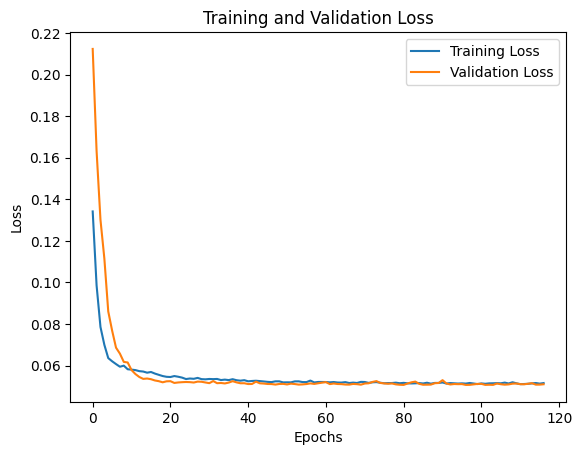

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0568 - mae: 0.1615
Mean Squared Error on test set: [0.059276897460222244, 0.16583874821662903]


In [41]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.show()

# đánh giá mô hình trên tập test
mse = model.evaluate(F_test, y_test)
print(f'Mean Squared Error on test set: {mse}')

# **4. Dự đoán**

In [42]:
input_vector = np.zeros(len(F.columns))
input_vector  # vector 1D

array([0., 0., 0., 0., 0., 0.])

In [43]:
np.zeros(len(F.columns)).reshape(1, len(F.columns))

array([[0., 0., 0., 0., 0., 0.]])

In [44]:
F.columns

Index(['Capacity', 'Re', 'Rct', 'type_charge', 'type_discharge',
       'type_impedance'],
      dtype='object')

In [45]:
F.columns.get_loc('type_charge')

3

In [46]:
# chuẩn bị đầu vào
def prepare_input(type, Capacity, Re, Rct):
    input_vector = np.zeros(3).reshape(1, 3) # 2D (1, 3)

    input_vector[0][F.columns.get_loc('Capacity')] = Capacity
    input_vector[0][F.columns.get_loc('Re')] = Re
    input_vector[0][F.columns.get_loc('Rct')] = Rct

    type_encoded = onehot_encoder.transform(np.array([[type]]))

    # encoding
    F_predict = np.concatenate((input_vector, type_encoded), axis=1)

    # scaling
    F_predict = scaler_F.transform(F_predict)

    return F_predict

In [47]:
# dự đoán
def predict_battery_life(**predict_input):
    F_predict = prepare_input(**predict_input)

    # đầu ra dự đoán (ambient_temperature)
    y_predict = model.predict(F_predict)

    return scaler_y.inverse_transform(y_predict)[0]

In [48]:
# test dữ liệu mẫu
battery_life1 = predict_battery_life(type = 'discharge', Capacity = 1.674305, Re = -4.976500e+11, Rct = 1.055903e+12)

print(f"Predicted Battery Life: {battery_life1}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
Predicted Battery Life: [28.491022]


In [49]:
# test dữ liệu mẫu: 4
battery_life2 = predict_battery_life(type = 'discharge', Capacity = 0.990759, Re = 0.072553, Rct = 0.101419)

print(f"Predicted Battery Life: {battery_life2}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
Predicted Battery Life: [5.9538174]


In [50]:
# test dữ liệu mẫu: 24
battery_life3 = predict_battery_life(type = 'impedance', Capacity = 1.428065, Re = 0.053192, Rct = 0.164734)

print(f"Predicted Battery Life: {battery_life3}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
Predicted Battery Life: [24.258667]


# **5. Lưu file**

In [51]:
import pickle

pickle_dir_path="/content/drive/MyDrive/Colab Notebooks/electric-vehicle-battery-life-prediction/pickle"

with open(f'{pickle_dir_path}/model.pkl', 'wb') as f1:
    pickle.dump(model, f1)

with open(f'{pickle_dir_path}/scaler_F.pkl', 'wb') as f2:
    pickle.dump(scaler_F, f2)

with open(f'{pickle_dir_path}/scaler_y.pkl', 'wb') as f3:
    pickle.dump(scaler_y, f3)

with open(f'{pickle_dir_path}/onehot_encoder.pkl', 'wb') as f4:
    pickle.dump(onehot_encoder, f4)

model.save(f"{pickle_dir_path}/model.h5")